# Train model CNN to recognize comment generated and original voice of different person **Combined Dataset Mixing** Hyper Parameters 2

In [1]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from enum import Enum
import pandas as pd
from pathlib import Path
from torchvision.transforms.functional import normalize
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import sys
sys.path.append('../')

In [3]:
def filter_sample_by_clients_ids(data: pd.DataFrame, max_count: int = 500, min_count: int = 4):
	sample_count = data['client_id'].value_counts()
	clients_ids = [e for e in sample_count[sample_count < max_count][sample_count > min_count].index]
	return data[data['client_id'].isin(clients_ids)]

def concatenation(train_data: pd.DataFrame, anchor: pd.DataFrame, posneg: pd.DataFrame) -> pd.DataFrame:
		data_particle_case = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
		data_particle_case[['anchor_client_id', 'anchor_path', 'anchor_source']] = anchor
		data_particle_case[['posneg_client_id', 'posneg_path', 'posneg_source']] = posneg
		return pd.concat([train_data, data_particle_case], ignore_index=True)


def generate_combined_dataset(original_data: pd.DataFrame, generated_data: pd.DataFrame, data_frac: int = 0.5) -> pd.DataFrame:
	client_ids = original_data['client_id'].unique()
	original_data['source'] = 'original'
	generated_data['source'] = 'generated'
	
	train_data = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
	for id in client_ids:

		original_id_sample = original_data[original_data['client_id'] == id]
		generated_id_sample = generated_data[generated_data['client_id'] == id]
		original_no_client_id_sample = original_data[original_data['client_id'] != id]

		anchor_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		positive_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		train_data = concatenation(train_data, anchor_original, positive_original)


		anchor_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		negative_original = original_no_client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		train_data = concatenation(train_data, anchor_original, negative_original)

		anchor_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		positive_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		train_data = concatenation(train_data, anchor_original, positive_original)

		anchor_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		negative_generated = generated_id_sample.sample(frac=data_frac).reset_index(drop=True)
		train_data = concatenation(train_data, anchor_original, negative_generated)
	
	return train_data

In [4]:
SAMPLE_RATE = 16000
DATASET_PATH = '../dataset/'
DATA_PATH = '../data/'
MODEL_SAVE_PATH = '../model_save/'
BATCH_SIZE = 24

In [5]:
from src.dataset.universal_dataset import UniversalDS

class UniversalCombinedDS(UniversalDS):

	def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
		label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
		return torch.tensor(1 if label else 0, dtype=torch.int64)
	
	def mix_dataset(self):
		self.temp_dataset = generate_combined_dataset(self.voice_dataset, self.generated_voice_dataset, data_frac=1)
		self.reset_iteration()


In [6]:
import librosa

from src.columns.combined_dataset_column import CombinedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class CombinedSoundDS(Dataset):
    def __init__(
        self,
        voiceDataset,
        original_voice_data_path,
        generated_voice_data_path,
        sample_rate=16000,
        duration=3,
        transform=None
    ):
        self.voiceDataset = voiceDataset
        self.original_voice_data_path = str(original_voice_data_path)
        self.generated_voice_data_path = str(generated_voice_data_path)
        self.duration = duration
        self.sample_rate = sample_rate
        self.transform = None
        if transform is not None:
            self.transform = transform
        else:
            self.transform = CompositeTransformation(
                [
                    ResampleTransform(target_sample_rate=sample_rate),
                    CustomAdjustDurationTransform(duration_seconds=duration),
                    ToMelSpectrogramTransform(
                        sample_rate=sample_rate, n_mels=64, n_fft=512)
                ]
            )

    def __len__(self):
        return len(self.voiceDataset)

    def _get_sgram(self, audio_file):
        audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
        spectrogram = self.transform.transform((audio, sample_rate))
        return spectrogram

    def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
        label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
        return torch.tensor(1 if label else 0, dtype=torch.int64)

    def _get_sample_path(self, path, source):
        data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
        return data_path + path

    def __getitem__(self, idx):
        anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.voiceDataset.iloc[idx][
            [
                CombinedDatasetColumn.ANCHOR_PATH,
                CombinedDatasetColumn.POSNEG_PATH,
                CombinedDatasetColumn.ANCHOR_ID,
                CombinedDatasetColumn.POSNEG_ID,
                CombinedDatasetColumn.SOURCE_ANCHOR,
                CombinedDatasetColumn.SOURCE_POSNEG
            ]
        ].values.tolist()

        anchor_file = self._get_sample_path(anchor_path, anchor_source)
        posneg_file = self._get_sample_path(posneg_path, posneg_source)
        label = self._get_label(
            anchor_client_id, posneg_client_id, anchor_source, posneg_source)
        anchor_sgram = self._get_sgram(anchor_file)
        posneg_sgram = self._get_sgram(posneg_file)

        return anchor_sgram, posneg_sgram, label

In [7]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation
SAMPLE_RATE = 16000
train_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)

In [8]:
voice_df = pd.read_csv(DATA_PATH + "validated.tsv",  sep='\t')
voice_df = filter_sample_by_clients_ids(voice_df, min_count=3)[['client_id', 'path']]

generated_df = pd.read_csv(DATA_PATH + "generated.tsv",  sep='\t')
generated_df = filter_sample_by_clients_ids(generated_df, min_count=3)[['client_id', 'generated_path']]
train_ds = UniversalCombinedDS(voice_dataset=voice_df, generated_voice_dataset=generated_df, voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=train_transform)

test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=test_transform)

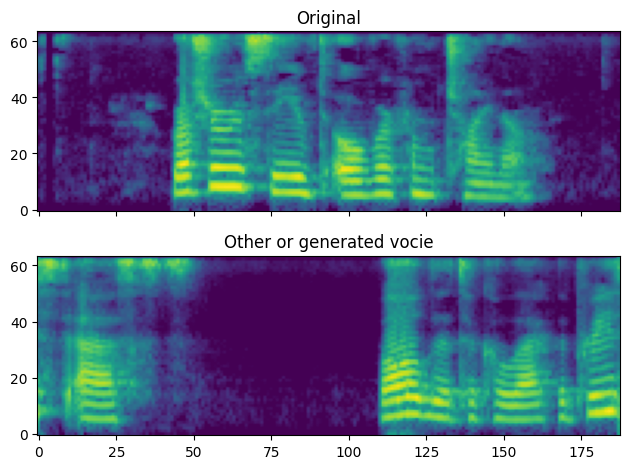

In [9]:
from src.utils.plot import plot

plot(test_ds[111])
train_ds.reset_iteration()

In [10]:
class SiameseNetwork(nn.Module):
		def __init__(self):
				super(SiameseNetwork, self).__init__()
				self.conv_layers = nn.Sequential(
						nn.Conv2d(1, 32, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(32, 64, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(64, 128, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(128, 256, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
				)
				self.fc_layers = nn.Sequential(
						nn.Linear(4608, 1024),
						nn.ReLU(inplace=True),
				)

				self.final = nn.Linear(1024, 2)

		def forward_once(self, x):

				x = self.conv_layers(x)
				x = x.view(x.size(0), -1)
				x = self.fc_layers(x)
				return x

		def forward(self, input1, input2):
			output1 = self.forward_once(input1)
			output2 = self.forward_once(input2)
			return self.final(torch.abs(output1 - output2))

In [11]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def evaluate_siamese_model(model, dataloader, criterion, device='cpu'):
	model.eval()
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred) for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)

	return avg_loss, accuracy, precision, recall, f1

In [13]:
def train_siamese_model(model, dataloader, criterion, optimizer, device='cpu'):
	model.train()
	total_loss = 0.0
	predictions = []
	true_labels = []

	for batch in tqdm(dataloader, desc="Training", leave=False):
		anchor_sgram, posneg_sgram, label = batch
		anchor_sgram = anchor_sgram.to(device)
		posneg_sgram = posneg_sgram.to(device)
		label = label.to(device)
		
		optimizer.zero_grad()
		output = model(anchor_sgram, posneg_sgram)
		loss = criterion(output, label)
		loss.backward()
		optimizer.step()
		total_loss += loss.item()
		predictions += [torch.argmax(pred) for pred in output.cpu()]
		true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)
	avg_loss = total_loss / len(dataloader)
	
	return avg_loss, accuracy, precision, recall, f1

In [14]:
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()

    def forward(self, output, label):
        label = label.long()
        loss = F.cross_entropy(output, label)
        return loss

In [15]:
num_epochs = 10
siamese_model = SiameseNetwork().to('cuda')
criterion = CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
import copy
loss, accuracy, precision, recall, f1 = [], [], [], [], []
best_accuracy=0
for epoch in range(num_epochs):
	_train_loss, _train_accuracy, _train_precision, _train_recall, _train_f1 = train_siamese_model(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}, "f"Accuracy: {_train_accuracy:.4f}, Precision: {_train_precision:.4f}, Recall: {_train_recall:.4f}, F1: {_train_f1:.4f}")
	_test_loss, _test_accuracy, _test_precision, _test_recall, _test_f1 = evaluate_siamese_model(siamese_model, test_dl, criterion, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}, "f"Accuracy: {_test_accuracy:.4f}, Precision: {_test_precision:.4f}, Recall: {_test_recall:.4f}, F1: {_test_f1:.4f}")
	if _test_accuracy > best_accuracy:
		best_accuracy = _test_accuracy
		best_model = copy.deepcopy(siamese_model)
	loss.append([_train_loss, _test_loss])
	accuracy.append([_train_accuracy, _test_accuracy])
	precision.append([_train_precision, _test_precision])
	recall.append([_train_recall, _test_recall])
	f1.append([_train_f1, _test_f1])

Epoch 1/10, Loss: 0.5930, Accuracy: 0.6658, Precision: 0.6758, Recall: 0.6374, F1: 0.6561


Epoch 1/10, Loss: 0.4852, Accuracy: 0.7832, Precision: 0.8109, Recall: 0.7386, F1: 0.7731


Epoch 2/10, Loss: 0.4859, Accuracy: 0.7672, Precision: 0.7574, Recall: 0.7862, F1: 0.7716


Epoch 2/10, Loss: 0.4474, Accuracy: 0.7873, Precision: 0.7230, Recall: 0.9315, F1: 0.8141


Epoch 3/10, Loss: 0.4195, Accuracy: 0.8128, Precision: 0.7966, Recall: 0.8400, F1: 0.8177


Epoch 3/10, Loss: 0.4623, Accuracy: 0.7873, Precision: 0.7223, Recall: 0.9336, F1: 0.8145


Epoch 4/10, Loss: 0.3791, Accuracy: 0.8374, Precision: 0.8158, Recall: 0.8714, F1: 0.8427


Epoch 4/10, Loss: 0.4151, Accuracy: 0.8257, Precision: 0.7617, Recall: 0.9481, F1: 0.8447


Epoch 5/10, Loss: 0.3668, Accuracy: 0.8440, Precision: 0.8213, Recall: 0.8794, F1: 0.8494


Epoch 5/10, Loss: 0.4253, Accuracy: 0.7967, Precision: 0.7483, Recall: 0.8942, F1: 0.8147


Epoch 6/10, Loss: 0.3360, Accuracy: 0.8573, Precision: 0.8337, Recall: 0.8928, F1: 0.8622


Epoch 6/10, Loss: 0.3620, Accuracy: 0.8465, Precision: 0.7869, Recall: 0.9502, F1: 0.8609


Epoch 7/10, Loss: 0.3219, Accuracy: 0.8612, Precision: 0.8383, Recall: 0.8949, F1: 0.8657


Epoch 7/10, Loss: 0.3510, Accuracy: 0.8413, Precision: 0.8098, Recall: 0.8921, F1: 0.8490


Epoch 8/10, Loss: 0.3027, Accuracy: 0.8756, Precision: 0.8518, Recall: 0.9094, F1: 0.8797


Epoch 8/10, Loss: 0.3402, Accuracy: 0.8537, Precision: 0.8311, Recall: 0.8880, F1: 0.8586


Epoch 9/10, Loss: 0.2923, Accuracy: 0.8794, Precision: 0.8560, Recall: 0.9121, F1: 0.8832


Epoch 9/10, Loss: 0.3407, Accuracy: 0.8610, Precision: 0.8222, Recall: 0.9212, F1: 0.8689


Epoch 10/10, Loss: 0.2727, Accuracy: 0.8895, Precision: 0.8674, Recall: 0.9196, F1: 0.8927


Epoch 10/10, Loss: 0.3303, Accuracy: 0.8558, Precision: 0.8451, Recall: 0.8714, F1: 0.8580


In [37]:
for epoch in range(num_epochs):
	_train_loss, _train_accuracy, _train_precision, _train_recall, _train_f1 = train_siamese_model(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}, "f"Accuracy: {_train_accuracy:.4f}, Precision: {_train_precision:.4f}, Recall: {_train_recall:.4f}, F1: {_train_f1:.4f}")
	_test_loss, _test_accuracy, _test_precision, _test_recall, _test_f1 = evaluate_siamese_model(siamese_model, test_dl, criterion, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}, "f"Accuracy: {_test_accuracy:.4f}, Precision: {_test_precision:.4f}, Recall: {_test_recall:.4f}, F1: {_test_f1:.4f}")
	if _test_accuracy > best_accuracy:
		best_accuracy = _test_accuracy
		best_model = copy.deepcopy(siamese_model)
	loss.append([_train_loss, _test_loss])
	accuracy.append([_train_accuracy, _test_accuracy])
	precision.append([_train_precision, _test_precision])
	recall.append([_train_recall, _test_recall])
	f1.append([_train_f1, _test_f1])

Epoch 1/10, Loss: 0.2668, Accuracy: 0.8913, Precision: 0.8687, Recall: 0.9221, F1: 0.8946


Epoch 1/10, Loss: 0.2979, Accuracy: 0.8693, Precision: 0.8450, Recall: 0.9046, F1: 0.8737


Epoch 2/10, Loss: 0.2638, Accuracy: 0.8952, Precision: 0.8712, Recall: 0.9276, F1: 0.8985


Epoch 2/10, Loss: 0.3591, Accuracy: 0.8330, Precision: 0.8129, Recall: 0.8651, F1: 0.8382


Epoch 3/10, Loss: 0.2588, Accuracy: 0.8967, Precision: 0.8748, Recall: 0.9258, F1: 0.8996


Epoch 3/10, Loss: 0.3273, Accuracy: 0.8589, Precision: 0.8078, Recall: 0.9419, F1: 0.8697


Epoch 4/10, Loss: 0.2447, Accuracy: 0.9034, Precision: 0.8808, Recall: 0.9331, F1: 0.9062


Epoch 4/10, Loss: 0.3414, Accuracy: 0.8537, Precision: 0.8473, Recall: 0.8631, F1: 0.8551


Epoch 5/10, Loss: 0.2461, Accuracy: 0.9014, Precision: 0.8811, Recall: 0.9279, F1: 0.9039


Epoch 5/10, Loss: 0.3525, Accuracy: 0.8413, Precision: 0.8297, Recall: 0.8589, F1: 0.8440


KeyboardInterrupt: 

In [38]:
import matplotlib.pyplot as plt

def plot_metrix(loss, accuracy):
	epochs = range(1, len(loss) + 1)

	fig, axs = plt.subplots(2, 1, figsize=(12, 8))
	fig.suptitle("Model Metrics")


	axs[0].plot(epochs, [e[0] for e in loss], label=" Train loss", color="g")
	axs[0].plot(epochs, [e[1] for e in loss], label="Test loss", color="b")
	axs[0].set_title("Loss")
	axs[0].set_xlabel("Epoch")
	axs[0].set_ylabel("Loss")

	axs[1].plot(epochs, [e[0] for e in accuracy], label="Train accuracy", color="g")
	axs[1].plot(epochs, [e[1] for e in accuracy], label="Test accuracy", color="b")
	axs[1].set_title("Accuracy")
	axs[1].set_xlabel("Epoch")
	axs[1].set_ylabel("Accuracy")
	plt.tight_layout()
	plt.show()

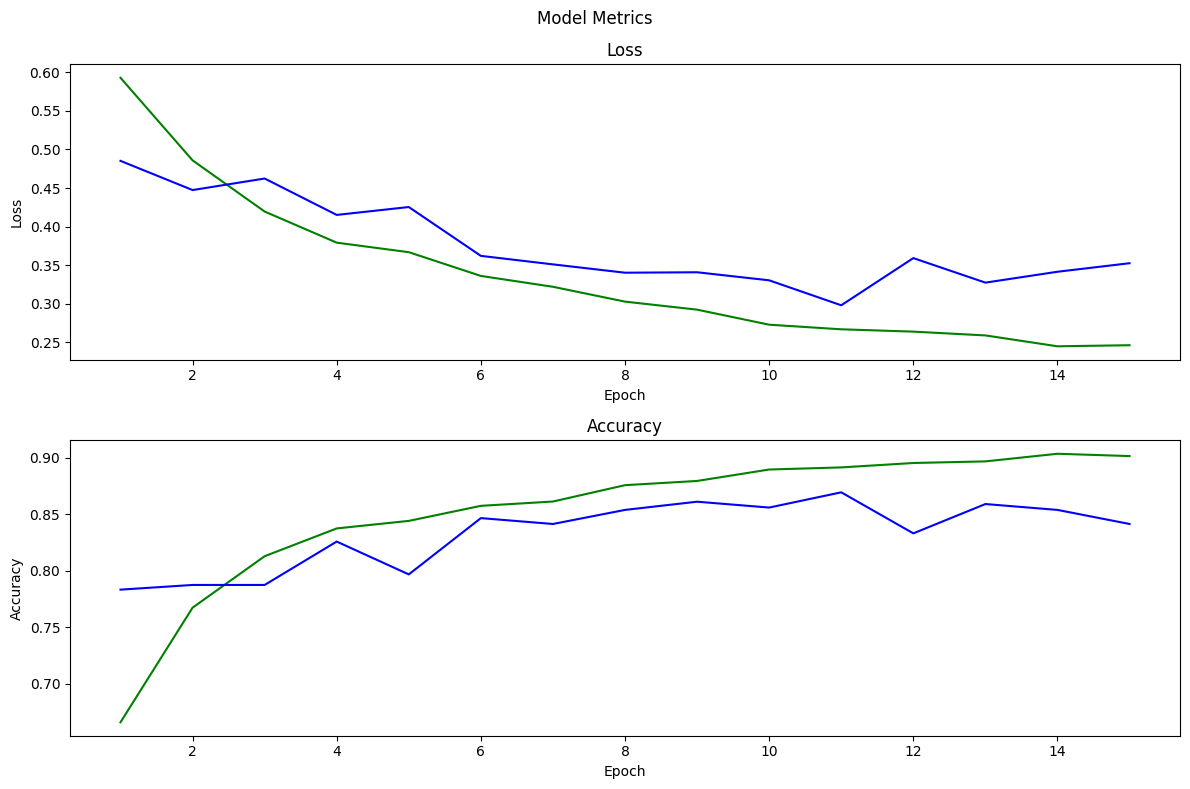

In [39]:
plot_metrix(loss, accuracy)

In [40]:
def save_model(model, model_name, base_path = '../model_save/'):
  model.cpu()
  model.eval()
  torch.save(model, base_path + model_name)

In [41]:
save_model(siamese_model, "combined_cnn_mix.pt")

In [46]:
def explain_model(model: torch.nn.Module, anchor_sgram: torch.tensor, posneg_sgram: torch.tensor, mode: str = "PREDICTED"):
	allowed_mode = ["GENERATED_CLASS, ORIGIN_CLASS", "PREDICTED"]
	if mode not in allowed_mode:
		raise ValueError()
	model.eval()
	model.cpu()
	model.zero_grad()
	anchor_sgram = torch.clone(anchor_sgram)
	posneg_sgram = torch.clone(posneg_sgram)

	anchor_sgram.unsqueeze_(0)
	posneg_sgram.unsqueeze_(0)
	anchor_sgram.requires_grad = True
	posneg_sgram.requires_grad = True

	anchor_sgram = anchor_sgram
	posneg_sgram = posneg_sgram

	predictions = model(anchor_sgram, posneg_sgram)
	if mode == "PREDICTED":
		class_id = predictions[0].argmax()
	if mode == "GENERATED_CLASS":
		class_id = 0
	if mode == "ORIGIN_CLASS":
		class_id = 1
	neuron = predictions[0, class_id]

	neuron.retain_grad()
	neuron.backward()
	anchor_slc, _ = torch.max(torch.abs(anchor_sgram.grad[0]), dim=0)
	anchor_grad = (anchor_slc - anchor_slc.min())/(anchor_slc.max()-anchor_slc.min())

	posneg_slc, _ = torch.max(torch.abs(posneg_sgram.grad[0]), dim=0)
	posneg_grad = (posneg_slc - posneg_slc.min())/(posneg_slc.max()-posneg_slc.min())

	return anchor_grad, posneg_grad

In [47]:
def plot_explain_siamese_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad, lable):

    plt.figure(figsize=(10, 2))
    plt.subplot(1, 2, 1)
    plt.title("Anchor Sgram")
    plt.imshow(anchor_sgram,  origin="lower", aspect="auto")
    plt.subplot(1, 2, 2)
    plt.title("Anchor Sgram Grad")
    text = "Positive" if lable.item() == 1 else "Negative"
    plt.imshow(anchor_sgram_grad.numpy(), cmap=plt.cm.hot,
               origin="lower", aspect="auto")
    plt.figure(figsize=(10, 2))
    plt.subplot(1, 2, 1)
    plt.title(f"{text} Sgram")
    plt.imshow(posneg_sgram,  origin="lower", aspect="auto")
    plt.subplot(1, 2, 2)
    plt.title(f"{text} Sgram Grad")
    plt.imshow(posneg_sgram_grad.numpy(), cmap=plt.cm.hot,
               origin="lower", aspect="auto")
    plt.show()

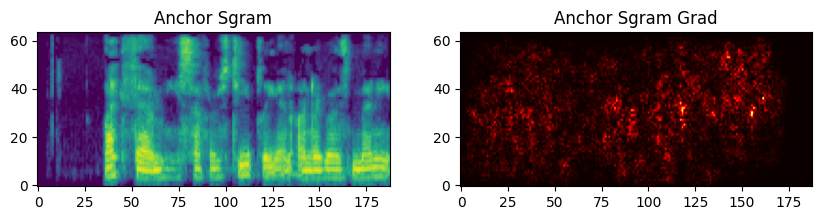

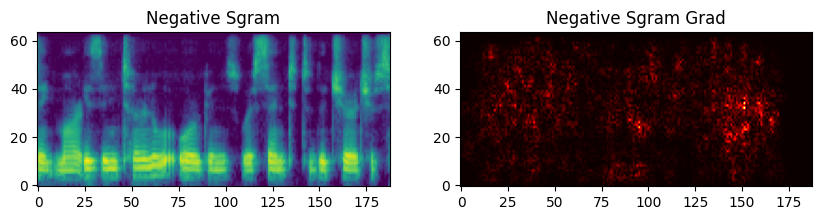

In [48]:
anchor_sgram, posneg_sgram, lable = test_ds[15]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad, lable)

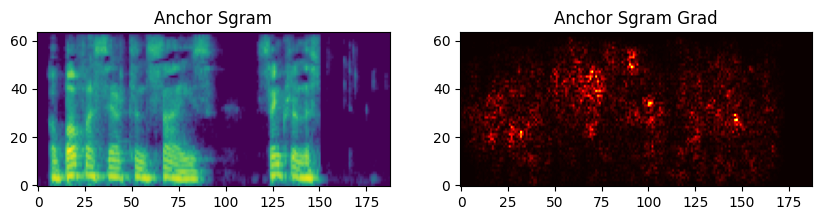

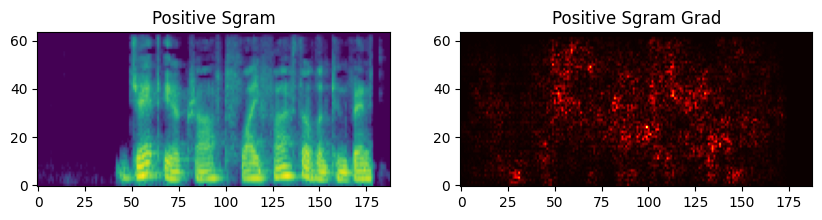

In [49]:


anchor_sgram, posneg_sgram, label = train_ds[33]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad, label)

In [50]:
def test(model, dataloader, criterion, device='cpu'):
	model.eval()
	model.to(device)
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred).item() for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]


	avg_loss = total_loss / len(dataloader)

	return avg_loss, true_labels, predictions

In [51]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
def displayConfusionMatrix(true_labels, predictions):
	matrix = confusion_matrix(y_true=true_labels, y_pred= predictions, normalize="true" )
	disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels =  [ "Negative","Positive"]) 
	disp.plot(cmap=plt.cm.Blues) 
	plt.show()

In [52]:
from src.dataset.base_dataset import BaseSoundDS


test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = BaseSoundDS(test_df, DATA_PATH + "validated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.7738589211618258


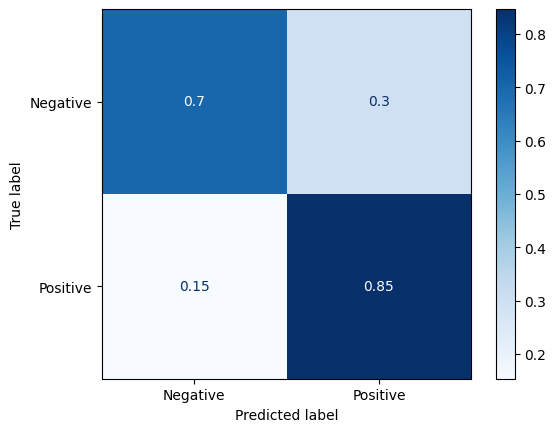

In [53]:
avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [54]:
from src.dataset.generated_dataset import GeneratedSoundDS

test_df = pd.read_csv(DATASET_PATH + "test_generated_dataset_.csv")
test_ds = GeneratedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

accuracy: 0.9107883817427386


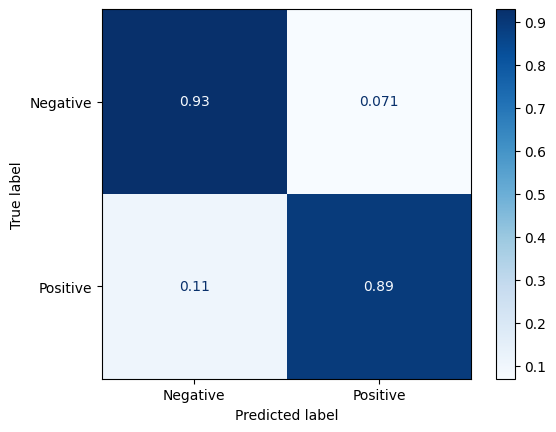

In [55]:
avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [60]:
from src.dataset.combined_dataset import CombinedSoundDS


test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)


accuracy: 0.8578838174273858


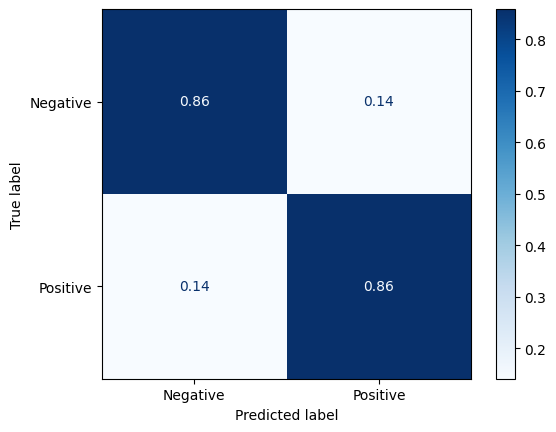

In [63]:
avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [64]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation
SAMPLE_RATE=16000
test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)
test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform = test_transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.8475103734439834


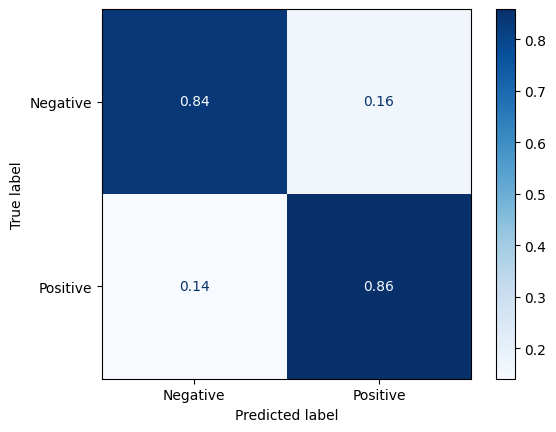

In [66]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)